# RPE exploratory and factor analysis

Similar to the wellnes data, in this notebook we are first going to clean up and imoute the RPE data, and then after visualizing how the training sessions for ecah player looks like, we separate the datapoints that did not do any kind of training and do a factor analysis and PCA on the days that players did training. This is necessary as there are a lot of missing values for the rows which the players did not do any training and we do not want those to affect our factor analysis or PCA.

## Load Data

In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pingouin as pg
import warnings 

warnings.filterwarnings('ignore')

In [2]:
np.random.seed(5151)
rpe_df = pd.read_csv('https://www.dropbox.com/s/2kgsd9x1fv1b7fl/rpe.csv?dl=1')

## Cleaning Data

In [3]:
len(rpe_df)

8860

To start with, we have 8860 observations.

In [4]:
len(rpe_df[(rpe_df['ObjectiveRating'].isnull()) | (rpe_df['FocusRating'].isnull()) | (rpe_df['BestOutOfMyself'].isnull())])


7151

Almost all the rows for the rpe data is missing at least one of: objective rating, focus rating, or best out of myself. We can impute the data for these columns but we need to keep in mind that we were missing a lot of this data.

In [5]:
# For datapoints that did do a training but their ratings are nan generate random ratings
# based on the current distribution of the values
for s in ['ObjectiveRating', 'FocusRating', 'BestOutOfMyself']:

    isnull = (rpe_df['Training']=='Yes') & (rpe_df[s].isnull())
    sample = rpe_df[(rpe_df['Training']=='Yes')][s].dropna().sample(isnull.sum(), replace=True).values
    rpe_df.loc[isnull, s] = sample

In [6]:
rpe_df['BestOutOfMyself'].value_counts()

Absolutely    6548
Not at all    1072
Somewhat       535
Name: BestOutOfMyself, dtype: int64

In [7]:
rpe_df['BestOutOfMyself'] = rpe_df['BestOutOfMyself'].map({'Absolutely': 2, 'Not at all': 0, 'Somewhat': 1})

In [8]:
rpe_df['SessionType'].value_counts()
rpe_df['Training'] = rpe_df['Training'].map({'Yes': 1, 'No': 0})
rpe_df[rpe_df['PlayerID'] == 1]

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
9,2018-07-19,1,1,Skills,60.0,3.0,180.0,180.0,87.9,140.54,0.63,9.0,8.0,0.0
20,2018-07-18,1,0,NaN,NaN,NaN,NaN,NaN,62.1,159.46,0.39,NaN,NaN,NaN
29,2018-07-17,1,1,Skills,60.0,3.0,180.0,195.0,62.1,173.93,0.36,9.0,9.0,2.0
30,2018-07-17,1,1,Mobility/Recovery,30.0,0.0,15.0,NaN,NaN,NaN,NaN,9.0,8.0,2.0
47,2018-07-16,1,1,Skills,60.0,3.0,180.0,240.0,34.3,166.96,0.21,8.0,8.0,2.0
48,2018-07-16,1,1,Speed,30.0,2.0,60.0,NaN,NaN,NaN,NaN,9.0,0.0,2.0
71,2018-07-14,1,0,NaN,NaN,NaN,NaN,NaN,51.4,215.89,0.24,NaN,NaN,NaN
77,2018-07-13,1,0,NaN,NaN,NaN,NaN,NaN,51.4,215.89,0.24,NaN,NaN,NaN
120,2018-07-10,1,1,Skills,90.0,4.0,360.0,360.0,85.0,228.75,0.37,9.0,9.0,0.0
182,2018-07-08,1,0,NaN,NaN,NaN,NaN,NaN,97.9,215.89,0.45,NaN,NaN,NaN


# Recomputing Session Loads

Now we need to recompute sessionloads (since previous session loads were sometimes miscalculated) and consecutively recompute daily loads chronic loads and acute loads for both cases were a player had a training or not. 

In [9]:
rpe_df['SessionLoad'] = rpe_df['Duration'] * rpe_df['RPE']

rpe_df.Date = pd.to_datetime(rpe_df.Date)
rpe_df = rpe_df.sort_values(by = 'Date', ascending = True)
print(rpe_df.head())
# Recomputing DailyLoad
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['SessionLoad'].transform('sum')
rpe_df[rpe_df['Date'] == '2017-09-06']

           Date  PlayerID  Training SessionType  Duration  RPE  SessionLoad  \
8859 2017-08-01        15         1    Strength      60.0  4.0        240.0   
8841 2017-08-01         1         1       Speed      60.0  3.0        180.0   
8842 2017-08-01         1         1    Strength      90.0  4.0        360.0   
8843 2017-08-01         3         1       Speed      45.0  5.0        225.0   
8844 2017-08-01         3         1    Strength      90.0  5.0        450.0   

      DailyLoad  AcuteLoad  ChronicLoad  AcuteChronicRatio  ObjectiveRating  \
8859        NaN        NaN          NaN                NaN              6.0   
8841      540.0       77.1        19.29                4.0              0.0   
8842        NaN        NaN          NaN                NaN              0.0   
8843      675.0       96.4        24.11                4.0              7.0   
8844        NaN        NaN          NaN                NaN              7.0   

      FocusRating  BestOutOfMyself  
8859         

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself
7911,2017-09-06,8,1,Mobility/Recovery,60.0,0.0,0.0,0.0,527.1,560.89,0.94,9.0,8.0,2.0
7906,2017-09-06,1,1,Mobility/Recovery,45.0,0.0,0.0,0.0,316.0,335.39,0.94,8.0,9.0,2.0
7907,2017-09-06,2,1,Mobility/Recovery,45.0,1.0,45.0,45.0,257.1,296.96,0.87,8.0,9.0,2.0
7908,2017-09-06,3,1,Mobility/Recovery,60.0,3.0,180.0,270.0,432.1,589.64,0.73,8.0,8.0,2.0
7909,2017-09-06,3,1,Mobility/Recovery,30.0,3.0,90.0,270.0,NaN,NaN,NaN,8.0,8.0,2.0
7912,2017-09-06,9,1,Strength,90.0,5.0,450.0,720.0,402.1,312.50,1.29,9.0,9.0,2.0
7910,2017-09-06,7,1,Mobility/Recovery,45.0,1.0,45.0,45.0,452.4,542.21,0.83,9.0,7.0,2.0
7914,2017-09-06,10,1,Mobility/Recovery,45.0,0.0,0.0,0.0,232.7,321.04,0.72,0.0,0.0,2.0
7915,2017-09-06,11,1,Mobility/Recovery,60.0,2.0,120.0,180.0,454.3,561.96,0.81,10.0,10.0,2.0
7916,2017-09-06,11,1,Mobility/Recovery,60.0,1.0,60.0,180.0,NaN,NaN,NaN,10.0,10.0,2.0


# Recomputing Daily load, Acute Load and Chronic Load

In [10]:
rpe_df['DailyLoad'] = rpe_df.groupby(['Date','PlayerID'])['DailyLoad'].fillna(method='ffill')

In [11]:
temp = rpe_df[['Date','PlayerID','DailyLoad']].drop_duplicates()
past7Days = temp.groupby('PlayerID').rolling('7d', on='Date')['DailyLoad'].sum().reset_index()
past7Days['newAcuteLoad'] = (past7Days['DailyLoad'] / 7.).round(2)
past7Days = past7Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past7Days, how="left", on=["Date", "PlayerID"])

In [12]:
past30Days = temp.groupby('PlayerID').rolling('30d', on='Date')['DailyLoad'].sum().reset_index()
past30Days['newChronicLoad'] = (past30Days['DailyLoad'] / 30.).round(2)
past30Days = past30Days.drop(columns = 'DailyLoad')

rpe_df = pd.merge(rpe_df, past30Days, how="left", on=["Date", "PlayerID"])
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
115  2017-08-07         1         1           Strength      90.0  4.0   
116  2017-08-07         1         1              Speed      60.0  3.0   
290  2017-08-14         1         1           Strength      90.0  5.0   
291  2017-08-14         1         1              Speed      60.0  4.0   
342  2017-08-16         1         1  Mobility/Recovery      45.0  0.0   
373  2017-08-17         1         1             Skills      90.0  3.0   
374  2017-08-17         1         1           Strength      60.0  4.0   
404  2017-08-18         1         1       Condition

# Recomputing Acute Chronic Ratio

In [13]:
rpe_df.drop(['ChronicLoad','AcuteLoad'],axis = 1, inplace = True)
rpe_df.rename(columns = {'newChronicLoad':'ChronicLoad','newAcuteLoad':'AcuteLoad'}, inplace = True)
rpe_df['AcuteChronicRatio'] = (rpe_df['AcuteLoad'] / rpe_df['ChronicLoad']).round(2)
print(rpe_df[rpe_df['PlayerID'] == 1])

           Date  PlayerID  Training        SessionType  Duration  RPE  \
1    2017-08-01         1         1              Speed      60.0  3.0   
2    2017-08-01         1         1           Strength      90.0  4.0   
19   2017-08-02         1         0                NaN       NaN  NaN   
41   2017-08-03         1         0                NaN       NaN  NaN   
114  2017-08-07         1         1             Skills      60.0  3.0   
115  2017-08-07         1         1           Strength      90.0  4.0   
116  2017-08-07         1         1              Speed      60.0  3.0   
290  2017-08-14         1         1           Strength      90.0  5.0   
291  2017-08-14         1         1              Speed      60.0  4.0   
342  2017-08-16         1         1  Mobility/Recovery      45.0  0.0   
373  2017-08-17         1         1             Skills      90.0  3.0   
374  2017-08-17         1         1           Strength      60.0  4.0   
404  2017-08-18         1         1       Condition

We can now save the processed version of rpe data. Also before doing the factor analysis, since there are a lot of missing field for days that players did not do any training, it might be a good idea to separate the two datasets and do the factor analysis on them separately.

In [14]:
print(len(rpe_df))
rpe_df.to_csv('./processed_data/processed_rpe.csv')

training_yes = rpe_df[rpe_df['Training'] == 1].drop(['Training'], axis=1)
training_no = rpe_df[rpe_df['Training'] == 0].drop(['Training'], axis=1)
print(len(training_yes))

8860
7622


Before preparing the data for doing factor analysis, it is a good idea to see the distribution of training sessions after cleaning the RPE data to get an idea about how many training sessions each player has participated in.

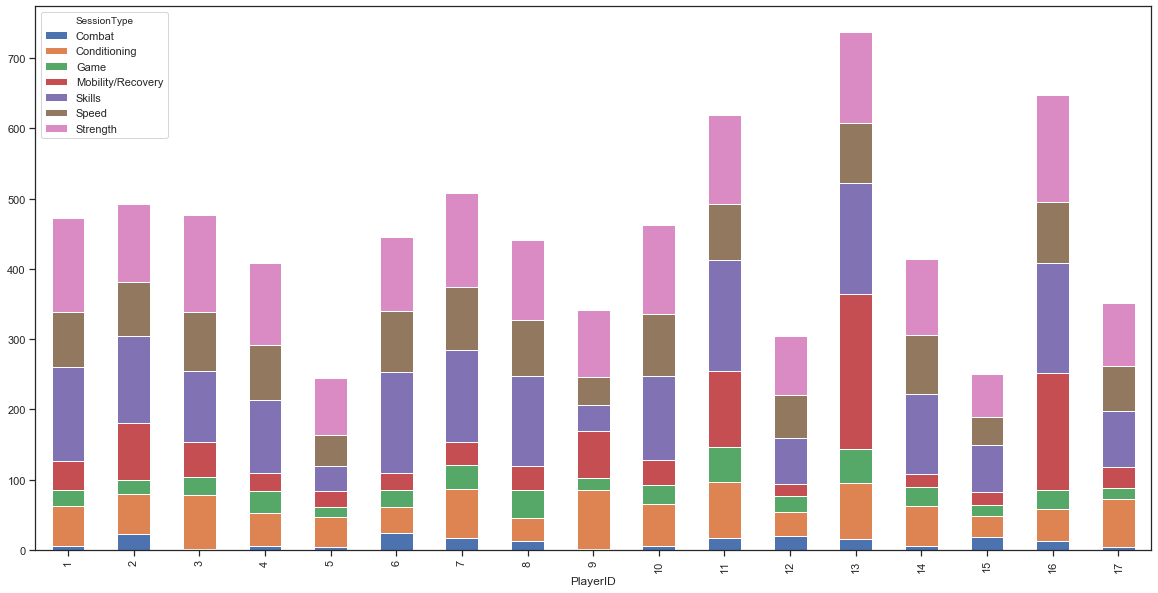

In [15]:
session_type_by_player_id = training_yes.groupby(['PlayerID', 'SessionType'])['Date'].count().unstack('SessionType').fillna(0)
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
session_type_by_player_id.plot(ax=ax1, kind='bar', stacked=True)
plt.show()

We can see that the distribution of traning session are fairly similar over all players, except for the Mobility/Recovery session which is significantly higher for player 13 compared to other players.

In [16]:
print(len(training_no),len(training_no[training_no['SessionType'].isnull()]))
print(training_no['SessionType'].value_counts())
print(training_no[training_no['SessionType']=='Conditioning'])
print(training_no['ObjectiveRating'].value_counts())
print(training_no['FocusRating'].value_counts())
print(training_no['BestOutOfMyself'].value_counts())

1238 1237
Conditioning    1
Name: SessionType, dtype: int64
           Date  PlayerID   SessionType  Duration  RPE  SessionLoad  \
3241 2017-11-30         3  Conditioning      30.0  5.0        150.0   

      DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
3241     1180.0                0.9              8.0          8.0   

      BestOutOfMyself  AcuteLoad  ChronicLoad  
3241              2.0     407.86       454.67  
0.0    3
8.0    1
7.0    1
Name: ObjectiveRating, dtype: int64
0.0    3
8.0    1
7.0    1
Name: FocusRating, dtype: int64
2.0    449
1.0     60
0.0     24
Name: BestOutOfMyself, dtype: int64


There was only one datapoint that by mistake the training field was marked as a No, while it was a conditioning training. So we add that to the training_yes group and remove it from the training_no group. Also since there were only 5 datapoints that had focus rating and objective rating we can remove these two columns from the training_no group.

In [17]:
print(len(training_yes))
tmp_df = training_no[training_no['SessionType']=='Conditioning']
training_yes = pd.concat([training_yes, tmp_df])
print(len(training_yes))
print(len(training_no))
training_no = training_no[training_no['SessionType'].isnull()]
print(len(training_no))

7622
7623
1238
1237


In [18]:
# Removing rows that had dailyloads (since it means they did do
# trainings on that day after all and there are only 13 of them)
training_no = training_no[training_no['DailyLoad'] == 0]
print(len(training_no))

1222


In [19]:
# Remove unnecessary columns
training_no.dropna(axis = 1, how = 'all',inplace = True)
training_no.drop(['ObjectiveRating', 'FocusRating','DailyLoad'],axis=1, inplace = True)
print(training_no.columns)

Index(['Date', 'PlayerID', 'AcuteChronicRatio', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad'],
      dtype='object')


Before preparing the data for factor analysis, it is also nice to see the correlation between different variables using repeated measure correlation:

In [20]:
corr_training =  training_yes.copy()
corr_training['SessionType'] = corr_training['SessionType'].map({'Combat': 0, 'Conditioning': 1,
                                                                 'Game': 2,
                                                                 'Mobility/Recovery': 3,
                                                                 'Skills': 4,
                                                                 'Speed': 5,'Strength': 6})
for i in corr_training.columns:
    if i == 'Date' or i == 'PlayerID':
        continue
        
    for j in corr_training.columns:
        if j == 'Date' or j == 'PlayerID' or i == j:
            continue
            
        print('Repeated Measures Correlation Result for {} and {}'.format(i, j))
        print(pg.rm_corr(data= corr_training, x=i, y=j, subject='PlayerID'))

Repeated Measures Correlation Result for SessionType and Duration
             r   dof           pval         CI95%  power
rm_corr  0.414  7603  3.220236e-312  [0.39, 0.43]    1.0
Repeated Measures Correlation Result for SessionType and RPE
             r   dof          pval           CI95%  power
rm_corr -0.067  7603  4.552371e-09  [-0.09, -0.04]    1.0
Repeated Measures Correlation Result for SessionType and SessionLoad
             r   dof           pval         CI95%  power
rm_corr  0.266  7603  3.545668e-123  [0.24, 0.29]    1.0
Repeated Measures Correlation Result for SessionType and DailyLoad
             r   dof          pval         CI95%  power
rm_corr  0.134  7603  1.229759e-31  [0.11, 0.16]    1.0
Repeated Measures Correlation Result for SessionType and AcuteChronicRatio
             r   dof          pval        CI95%  power
rm_corr  0.074  7603  1.347399e-10  [0.05, 0.1]    1.0
Repeated Measures Correlation Result for SessionType and ObjectiveRating
             r   dof   

             r   dof      pval         CI95%  power
rm_corr  0.022  7605  0.057328  [-0.0, 0.04]  0.477
Repeated Measures Correlation Result for DailyLoad and AcuteLoad
             r   dof  pval        CI95%  power
rm_corr  0.487  7605   0.0  [0.47, 0.5]    1.0
Repeated Measures Correlation Result for DailyLoad and ChronicLoad
             r   dof          pval        CI95%  power
rm_corr  0.224  7605  2.850311e-87  [0.2, 0.25]    1.0
Repeated Measures Correlation Result for AcuteChronicRatio and SessionType
             r   dof          pval        CI95%  power
rm_corr  0.074  7603  1.347399e-10  [0.05, 0.1]    1.0
Repeated Measures Correlation Result for AcuteChronicRatio and Duration
             r   dof          pval         CI95%  power
rm_corr  0.138  7603  8.281089e-34  [0.12, 0.16]    1.0
Repeated Measures Correlation Result for AcuteChronicRatio and RPE
             r   dof      pval          CI95%  power
rm_corr  0.014  7603  0.219904  [-0.01, 0.04]  0.232
Repeated Measures 

             r   dof  pval        CI95%  power
rm_corr  0.487  7605   0.0  [0.47, 0.5]    1.0
Repeated Measures Correlation Result for AcuteLoad and AcuteChronicRatio
            r   dof           pval         CI95%  power
rm_corr  0.34  7605  1.025404e-204  [0.32, 0.36]    1.0
Repeated Measures Correlation Result for AcuteLoad and ObjectiveRating
             r   dof      pval          CI95%  power
rm_corr -0.014  7605  0.237678  [-0.04, 0.01]  0.219
Repeated Measures Correlation Result for AcuteLoad and FocusRating
             r   dof      pval         CI95%  power
rm_corr -0.018  7605  0.123477  [-0.04, 0.0]  0.338
Repeated Measures Correlation Result for AcuteLoad and BestOutOfMyself
             r   dof      pval         CI95%  power
rm_corr  0.049  7605  0.000023  [0.03, 0.07]  0.989
Repeated Measures Correlation Result for AcuteLoad and ChronicLoad
             r   dof  pval         CI95%  power
rm_corr  0.491  7605   0.0  [0.47, 0.51]    1.0
Repeated Measures Correlation Resul

In [21]:
# Convert categorical session type to dummy variable
training_yes = pd.get_dummies(training_yes, columns = ['SessionType'])

One of the interesting things that the repeated measure correlation shows us is that the correlation between duration and RPE is 0.257, which shows that we can not ignore one of these vraibles and probably a function of the two such as their product is indeed a reasonable estimate of session load.

In [22]:
training_no.to_csv('./processed_data/training_no.csv')
training_yes.to_csv('./processed_data/training_yes.csv')


### Repeated measures correlation

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [23]:
player_data_yes = training_yes.groupby('PlayerID',as_index = False).mean()
print(player_data_yes.head())
player_id_series = player_data_yes['PlayerID']
new_df_yes = player_data_yes.drop(['PlayerID'], axis=1)
print(new_df_yes.corr())
chi_square_value,p_value = calculate_bartlett_sphericity(new_df_yes)
print(chi_square_value, p_value)

yes_without_session_type = new_df_yes.drop(['SessionType_Combat',
                                        'SessionType_Conditioning',
                                       'SessionType_Game',
                                       'SessionType_Mobility/Recovery',
                                       'SessionType_Skills',
                                       'SessionType_Speed',
                                       'SessionType_Strength'],axis=1)
print(yes_without_session_type.columns)

kmo_all,kmo_model=calculate_kmo(yes_without_session_type)
print(kmo_all, kmo_model)

   PlayerID   Duration       RPE  SessionLoad   DailyLoad  AcuteChronicRatio  \
0         1  62.807203  3.476695   247.175847  667.213983           1.141208   
1         2  51.758621  4.241379   236.977688  724.131313           1.258909   
2         3  58.376569  4.995816   300.866109  783.217573           1.253975   
3         4  63.384804  4.497549   295.147059  727.541667           1.242892   
4         5  56.828571  4.281633   253.873469  666.591837           1.387388   

   ObjectiveRating  FocusRating  BestOutOfMyself   AcuteLoad  ChronicLoad  \
0         8.031780     8.218220         1.728814  371.749788   345.053305   
1         8.046465     8.149495         1.666667  390.753374   339.576566   
2         8.033473     7.981172         1.922594  467.025377   411.348703   
3         7.801471     7.867647         1.708333  397.827108   345.876838   
4         8.273469     8.575510         1.644898  275.206571   230.881633   

   SessionType_Combat  SessionType_Conditioning  Session

### Adequacy Tests for factor analysis

In [24]:
player_data_no = training_no.groupby('PlayerID',as_index = False).mean()
new_df_no = player_data_no.drop(['PlayerID'], axis=1)

no_without_nan_columns = new_df_no.drop(['BestOutOfMyself'],axis=1)

# Chi square test for factor analysis
chi_square_value,p_value = calculate_bartlett_sphericity(no_without_nan_columns)
print(chi_square_value, p_value)

# kmo test for factor analysis
kmo_all,kmo_model=calculate_kmo(no_without_nan_columns)
print(kmo_all, kmo_model)

71.45673357377878 1.0263585459218795e-15
[0.11161378 0.34029549 0.35685836] 0.2907159948923859


# Factor analysis

In [25]:
def factor_scree_plot(factor_num, data, rotation = None):
    factor_number_tester = FactorAnalyzer(n_factors= factor_num, rotation= rotation) # Using number of factors = number of columns
    factor_number_tester.fit(data) 
    ev, v = factor_number_tester.get_eigenvalues()

    plt.scatter(range(1, data.shape[1]+1),ev)
    plt.plot(range(1, data.shape[1]+1),ev)
    plt.title('Scree Plot')
    plt.xlabel('Factors')
    plt.ylabel('Eigenvalue')
    plt.grid()
    plt.show()

def view_factor_loadings(factor_num, data, rotation = None):
    
    fa = FactorAnalyzer(factor_num, rotation= rotation)
    fa.fit(data)
    print(data.columns)
    print(fa.loadings_)
    print(np.where(fa.loadings_>0.7))
    print(fa.get_factor_variance())


Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteChronicRatio',
       'ObjectiveRating', 'FocusRating', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')


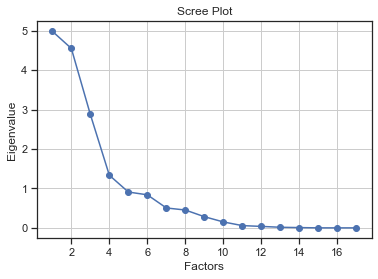

Index(['Duration', 'RPE', 'SessionLoad', 'DailyLoad', 'AcuteChronicRatio',
       'ObjectiveRating', 'FocusRating', 'BestOutOfMyself', 'AcuteLoad',
       'ChronicLoad', 'SessionType_Combat', 'SessionType_Conditioning',
       'SessionType_Game', 'SessionType_Mobility/Recovery',
       'SessionType_Skills', 'SessionType_Speed', 'SessionType_Strength'],
      dtype='object')
[[ 0.14718711  0.76807301  0.32984586  0.06312331]
 [ 0.03901437  0.27527341  0.03424177  0.89971804]
 [ 0.28815232  0.62122009  0.10275714  0.71146967]
 [ 0.48203683 -0.06389481  0.24691448  0.79785672]
 [-0.88350069  0.00511242 -0.08344958  0.02752502]
 [ 0.58066677 -0.21491108 -0.57906478  0.14307972]
 [ 0.29403853 -0.21834208 -0.5858944   0.30460126]
 [-0.04320934  0.4611468  -0.07258781  0.29442051]
 [ 0.84389551 -0.12227278  0.09113195  0.48405597]
 [ 0.91723239 -0.13991159  0.07746796  0.3596205 ]
 [-0.46098574 -0.29558038  0.48881343  0.01971512]
 [-0.24855749  0.17975939 -0.88613619  0.01174763]
 [ 0.054369

In [26]:
print(new_df_yes.columns)
factor_scree_plot(10, new_df_yes, "varimax")
view_factor_loadings(4, new_df_yes, "varimax")

These factors are hard to interpret. Given how much data we are missing for some columns (especially for days that the training field is set to No), we will use the acute chronic ratio for the measure of training load as we are assuming that this will have a relationship with performance. Also since the high loadings associated with the first factor in the factor analysis are acute load and chronic load, a function of the two which is acute chronic ratio can be a good measure of the training load.

# PCA on RPE data

[[   7.55692532   23.07353124]
 [ -30.22735546  -11.42717982]
 [-158.27140451  -18.27688724]
 [ -48.79359381  -29.51872457]
 [ 128.26755305  -64.95245042]
 [-166.78504482  -75.23192975]
 [-106.93871602   -7.03929445]
 [ -59.84874108    5.20639585]
 [  76.54875216   87.90442198]
 [  86.78293298   38.47683713]
 [-196.19355538    6.55377792]
 [ 252.50701698   26.88493554]
 [ -65.09274981   76.52479748]
 [ -11.39095157  -29.38840444]
 [ 209.47465882  -75.87733854]
 [ -74.99214158   51.43010677]
 [ 157.39641472   -4.34259468]]


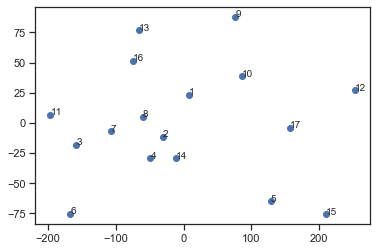

In [27]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(player_data_yes)
print(principal_components)

HORIZONTAL_OFFSET = 0
VERTICAL_OFFSET = 0

fig, ax = plt.subplots()
ax.scatter(principal_components[:, 0], principal_components[:, 1])

for i in range(len(player_id_series)):
    ax.annotate(str(i + 1), (principal_components[i, 0] + HORIZONTAL_OFFSET, principal_components[i, 1] + VERTICAL_OFFSET))

It is interesting how the rpe data is less clustered than the wellness data when we visualized them using PCA.